In [9]:
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

#### 定义网络

In [10]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=20, kernel_size=5, stride=1)
        self.fc1 = nn.Linear(in_features=20 * 12 * 12, out_features=100)
        self.fc2 = nn.Linear(100, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)  # kernel_size=2, stride=2，pooling之后的大小除以2
        x = x.view(-1, 20 * 12 * 12)  # 展开为行向量
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = F.log_softmax(x, dim=1)  # 按行进行log(softmax(x))
        return x

#### 数据加载

In [11]:
def data_loader(batch_size, batch_size_test, use_cuda=False):
    """
    数据加载器

    :param batch_size: 训练集批次大小
    :param batch_size_test:  测试集批次大小
    :param use_cuda: 是否使用GPU
    :return: 训练集和测试集
    """

    # GPU训练需要的参数
    kwargs = {'num_workers': 4, 'pin_memory': True} if use_cuda else {}

    train_loader = torch.utils.data.DataLoader(
        datasets.MNIST(root='./files/',
                       train=True,
                       download=True,
                       transform=transforms.Compose([
                           # 把[0,255]的(H,W,C)的图片转换为[0,1]的(channel,height,width)的图片
                           transforms.ToTensor(),
                           # z-score标准化为标准正态分布
                           # 这两个数分别是MNIST的均值和标准差
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])),
        batch_size=batch_size,
        shuffle=True,
        **kwargs)

    test_loader = torch.utils.data.DataLoader(
        datasets.MNIST(root='./files/',
                       train=False,
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])),
        batch_size=batch_size_test,
        shuffle=True,
        **kwargs)

    return train_loader, test_loader

#### 训练脚本

In [12]:
def train(log_interval, network, device, train_loader, train_losses, optimizer, epoch):
    """
    训练过程

    :param log_interval: 计算训练效果的间隔
    :param network: 网络模型
    :param device: 使用的设备 CPU or GPU
    :param train_loader: 训练集
    :param train_losses: 记录损失变化
    :param optimizer: 优化器
    :param epoch: 当前的迭代次数
    :return: null
    """
    network.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        # 每个batch重新计算梯度
        optimizer.zero_grad()
        # 前向计算出预测输出
        output = network(data)
        # 对数似然代价
        loss = F.nll_loss(output, target)
        # 求梯度
        loss.backward()
        # 更新参数
        optimizer.step()
        # 每经过一个log_interval大小的间隔，记录一下训练效果
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                       100. * batch_idx / len(train_loader), loss.item()))
            train_losses.append(loss.item())
            train_counter.append(
                (batch_idx * batch_size_train) + ((epoch - 1) * len(train_loader.dataset)))

#### 测试脚本

In [13]:
def test(network, device, test_loader, test_losses):
    """
    测试过程

    :param network: 网络模型
    :param device: 测试使用的设备
    :param test_loader: 测试集
    :param test_losses: 记录损失变化
    :return: null
    """
    network.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():  # 预测时不需要反向传播
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = network(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            predict = output.argmax(dim=1, keepdim=True)
            correct += predict.eq(target.view_as(predict)).sum().item()

    # 上面test_loss得到的是累加和，这里求得均值
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

### MAIN

In [14]:
n_epochs = 3
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10

random_seed = 1

# 启用英伟达cuDNN加速框架和CUDA
torch.backends.cudnn.enabled = True
torch.manual_seed(random_seed)
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print("using {}...".format("cuda" if use_cuda else "cpu"))

# 加载数据
train_loader, test_loader = data_loader(batch_size=batch_size_train, batch_size_test=batch_size_test, use_cuda=use_cuda)

train_losses = []
train_counter = []
test_losses = []
test_counter = [i * len(train_loader.dataset) for i in range(n_epochs + 1)]

network = Network().to(device)
optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)

for epoch in range(1, n_epochs + 1):
    train(log_interval, network, device, train_loader, train_losses, optimizer, epoch)
    test(network, device, test_loader, test_losses)



using cuda...
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.298396
Train Epoch: 1 [640/60000 (1%)]	Loss: 1.998022
Train Epoch: 1 [1280/60000 (2%)]	Loss: 1.627732
Train Epoch: 1 [1920/60000 (3%)]	Loss: 1.216517
Train Epoch: 1 [2560/60000 (4%)]	Loss: 0.802180
Train Epoch: 1 [3200/60000 (5%)]	Loss: 0.747045
Train Epoch: 1 [3840/60000 (6%)]	Loss: 0.575385
Train Epoch: 1 [4480/60000 (7%)]	Loss: 0.526559
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.469119
Train Epoch: 1 [5760/60000 (10%)]	Loss: 0.361926
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.521784
Train Epoch: 1 [7040/60000 (12%)]	Loss: 0.343188
Train Epoch: 1 [7680/60000 (13%)]	Loss: 0.539871
Train Epoch: 1 [8320/60000 (14%)]	Loss: 0.314487
Train Epoch: 1 [8960/60000 (15%)]	Loss: 0.217913
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.441859
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.431089
Train Epoch: 1 [10880/60000 (18%)]	Loss: 0.388443
Train Epoch: 1 [11520/60000 (19%)]	Loss: 0.477139
Train Epoch: 1 [12160/60000 (20%)]	Loss: 0.501813
Train Epoch: 1 

### 评估

Text(0, 0.5, 'negative log likelihood loss')

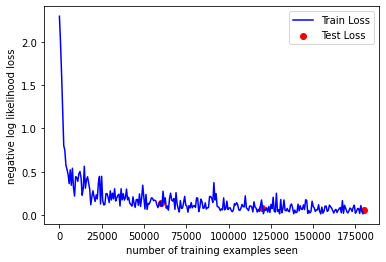

In [20]:
import matplotlib.pyplot as plt

fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter[1:], test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')